<a href="https://colab.research.google.com/github/YonDraco/learn-pyimagesearch/blob/master/1_Project_a_3D_Point_to_a_2D_Image_Starter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

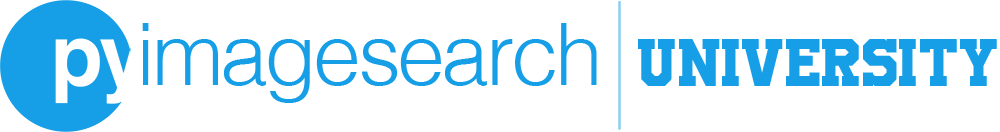

# Welcome to the LiDAR Camera Projection Workshop!

We are going to learn:
1. How to **Load a Point Cloud** and **Visualize it**
2. How to **Load an Image** and **Visualize it**
3. How to **fuse LiDAR and Camera manually** (i.e. without coding it)
4. How to **project LiDAR Point Clouds to an Image**
5. How to **run the algorithms on a video**

Ready? Let's get started!

### Install the necessary packages

In [ ]:
!pip install open3d==0.12.0 # Version 12
!pip install pypotree #https://github.com/centreborelli/pypotree

### Download the code zip file

In [ ]:
!wget https://pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com/visual-fusion-mini-course/data.zip
!unzip -qq data.zip
!mkdir output

### Import Packages

In [ ]:
# import the necessary packages
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import open3d as o3d
import numpy as np
import pypotree 
import glob
import cv2

### Load the Files

In [ ]:
image_files = sorted(glob.glob("data/img/*.png"))
point_files = sorted(glob.glob("data/velodyne/*.pcd"))
label_files = sorted(glob.glob("data/label/*.txt"))
calib_files = sorted(glob.glob("data/calib/*.txt"))

index = 0
pcd_file = point_files[index]
image = cv2.cvtColor(cv2.imread(image_files[index]), cv2.COLOR_BGR2RGB)
cloud = o3d.io.read_point_cloud(pcd_file)
points= np.asarray(cloud.points)

### Visualize the Image

In [ ]:
f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Image', fontsize=30)

### Visualize the Point Clouds

In [ ]:
cloudpath = pypotree.generate_cloud_for_display(points)
pypotree.display_cloud_colab(cloudpath)

##Project the Points in the Image <p>
That part is possibly the hardest to understand and will require your full attention. We want to project the 3D points into the image.<p>

It means we'll need to: <p>

*   Select the Point that are **visible** in the image 🤔
*   Convert the Points **from the LiDAR frame to the Camera Frame** 🤯
*   Find a way to project **from the Camera Frame to the Image Frame** 😭

<p>
No worries here, we'll figure out everything together.


### 1 - Read the Calibration File

The first step is to read the calibration files. For each image, we have an associated calibration file that states:<p>


*   The instrinsic and extrinsic camera calibration parameters
*   The velodyne to camera matrices
*   All the other "sensor A" to "sensor B" matrices
<p>
They are made from this setup:<p>

![car sensors](https://camo.githubusercontent.com/c4ef1bd91166555fec1e2b4db3f78368244e7c49/687474703a2f2f7777772e63766c6962732e6e65742f64617461736574732f6b697474692f696d616765732f73657475705f746f705f766965772e706e67)

Not everything matters to us here, only a few things:
*    **Velo-To-Cam is a variable we'll call V2C** -- It gives the rotation and translation matrices from the Velodyne to the Left Grayscale camera.
*    **R0_rect is used in Stereo Vision** to make the images co-planar. It's our case here.
*   **P2 is the matrix obtained after camera calibration**. It contains the intrinsic matrix K and the extrinsic.


In [ ]:
class LiDAR2Camera(object):
    def __init__(self, calib_file):
        calibs = self.read_calib_file(calib_file)
        P = calibs["P2"]
        self.P = np.reshape(P, [3, 4])
        # Rigid transform from Velodyne coord to reference camera coord
        V2C = calibs["Tr_velo_to_cam"]
        self.V2C = np.reshape(V2C, [3, 4])
        # Rotation from reference camera coord to rect camera coord
        R0 = calibs["R0_rect"]
        self.R0 = np.reshape(R0, [3, 3])

    def read_calib_file(self, filepath):
        """ Read in a calibration file and parse into a dictionary.
        Ref: https://github.com/utiasSTARS/pykitti/blob/master/pykitti/utils.py
        """
        data = {}
        with open(filepath, "r") as f:
            for line in f.readlines():
                line = line.rstrip()
                if len(line) == 0:
                    continue
                key, value = line.split(":", 1)
                # The only non-float values in these files are dates, which
                # we don't care about anyway
                try:
                    data[key] = np.array([float(x) for x in value.split()])
                except ValueError:
                    pass
        return data

In [ ]:
lidar2cam = LiDAR2Camera(calib_files[index])
print("P :"+str(lidar2cam.P))
print("-")
print("RO "+str(lidar2cam.R0))
print("-")
print("Velo 2 Cam " +str(lidar2cam.V2C))
print("-")
#print("Cam 2 Velo" + str(lidar2cam.C2V))

### 2 - Apply the Magic Formula

The main formula we'll use will be as follows:<p>
**Y(2D) = P x R0 x R|t x X (3D)** 

However, when looking at the dimensions:

*   P: [3x4]
*   R0: [3x3]
*   R|t = Velo2Cam: [3x4]
*   X: [3x1]

We'll need to convert some points into Homogeneous Coordinates:
* RO must go from 3x3 to 4x3
* x must go from 3x1 to 4x1

Then, to retrieve the cartesian system, we'll divide as explained in the course.

In [ ]:
def cart2hom(self, pts_3d):
    """ Input: nx3 points in Cartesian
        Oupput: nx4 points in Homogeneous by pending 1
    """
    n = pts_3d.shape[0]
    pts_3d_hom = np.hstack((pts_3d, np.ones((n, 1))))
    return pts_3d_hom

LiDAR2Camera.cart2hom = cart2hom

In [ ]:
def project_velo_to_image(self, pts_3d_velo):
    '''
    Input: 3D points in Velodyne Frame [nx3]
    Output: 2D Pixels in Image Frame [nx2]
    '''
    # REVERSE TECHNIQUE
    '''
    homogeneous = self.cart2hom(pts_3d_velo)  # nx4
    dotted_RT = np.dot(homogeneous, np.transpose(self.V2C)) #nx3
    dotted_with_RO = np.transpose(np.dot(self.R0, np.transpose(dotted_RT))) #nx3
    homogeneous_2 = self.cart2hom(dotted_with_RO) #nx4
    pts_2d = np.dot(homogeneous_2, np.transpose(self.P))  # nx3
    '''
    
    # NORMAL TECHNIQUE
    R0_homo = np.vstack([self.R0, [0, 0, 0]])
    R0_homo_2 = np.column_stack([R0_homo, [0, 0, 0, 1]])
    p_r0 = np.dot(self.P, R0_homo_2) #PxR0
    p_r0_rt =  np.dot(p_r0, np.vstack((self.V2C, [0, 0, 0, 1]))) #PxROxRT
    pts_3d_homo = np.column_stack([pts_3d_velo, np.ones((pts_3d_velo.shape[0],1))])
    p_r0_rt_x = np.dot(p_r0_rt, np.transpose(pts_3d_homo))#PxROxRTxX
    pts_2d = np.transpose(p_r0_rt_x)
    
    pts_2d[:, 0] /= pts_2d[:, 2]
    pts_2d[:, 1] /= pts_2d[:, 2]
    return pts_2d[:, 0:2]

LiDAR2Camera.project_velo_to_image = project_velo_to_image
print(points[:1,:3])
print("Euclidean Pixels "+str(lidar2cam.project_velo_to_image(points[:1,:3])))


### 1.3 - Get the Points in the Field Of View Only

In [ ]:
def get_lidar_in_image_fov(self,pc_velo, xmin, ymin, xmax, ymax, return_more=False, clip_distance=2.0):
    """ Filter lidar points, keep those in image FOV """
    pts_2d = self.project_velo_to_image(pc_velo)
    fov_inds = (
        (pts_2d[:, 0] < xmax)
        & (pts_2d[:, 0] >= xmin)
        & (pts_2d[:, 1] < ymax)
        & (pts_2d[:, 1] >= ymin)
    )
    fov_inds = fov_inds & (pc_velo[:, 0] > clip_distance) # We don't want things that are closer to the clip distance (2m)
    imgfov_pc_velo = pc_velo[fov_inds, :]
    if return_more:
        return imgfov_pc_velo, pts_2d, fov_inds
    else:
        return imgfov_pc_velo
    
LiDAR2Camera.get_lidar_in_image_fov = get_lidar_in_image_fov

In [ ]:
lidar2cam.get_lidar_in_image_fov(points[:1,:], 0, 0, image.shape[1], image.shape[0], True)


###1.4 -- Draw the Points in the Image

In [ ]:
def show_lidar_on_image(self, pc_velo, img, debug="False"):
    """ Project LiDAR points to image """
    imgfov_pc_velo, pts_2d, fov_inds = self.get_lidar_in_image_fov(
        pc_velo, 0, 0, img.shape[1], img.shape[0], True
    )
    if (debug==True):
        print("3D PC Velo "+ str(imgfov_pc_velo)) # The 3D point Cloud Coordinates
        print("2D PIXEL: " + str(pts_2d)) # The 2D Pixels
        print("FOV : "+str(fov_inds)) # Whether the Pixel is in the image or not
    self.imgfov_pts_2d = pts_2d[fov_inds, :]
    '''
    #homogeneous = np.hstack((imgfov_pc_velo, np.ones((imgfov_pc_velo.shape[0], 1))))
    homogeneous = self.cart2hom(imgfov_pc_velo)
    transposed_RT = np.dot(homogeneous, np.transpose(self.V2C))
    dotted_RO = np.transpose(np.dot(self.R0, np.transpose(transposed_RT)))
    self.imgfov_pc_rect = dotted_RO
    
    if debug==True:
        print("FOV PC Rect "+ str(self.imgfov_pc_rect))
    '''
    cmap = plt.cm.get_cmap("hsv", 256)
    cmap = np.array([cmap(i) for i in range(256)])[:, :3] * 255
    self.imgfov_pc_velo = imgfov_pc_velo
    
    for i in range(self.imgfov_pts_2d.shape[0]):
        #depth = self.imgfov_pc_rect[i,2]
        #print(depth)
        depth = imgfov_pc_velo[i,0]
        #print(depth)
        color = cmap[int( 510.0 / depth), :]
        cv2.circle(
            img,(int(np.round(self.imgfov_pts_2d[i, 0])), int(np.round(self.imgfov_pts_2d[i, 1]))),2,
            color=tuple(color),
            thickness=-1,
        )

    return img

LiDAR2Camera.show_lidar_on_image = show_lidar_on_image

In [ ]:
#img_3 = lidar2cam.show_lidar_on_image(points[:,:3], image)
img_3 = image.copy()
img_3 = lidar2cam.show_lidar_on_image(points[:,:3], img_3)
plt.figure(figsize=(14,7))
plt.imshow(img_3)
plt.show()

## Shooting a Portfolio Video

In [ ]:
video_images = sorted(glob.glob("data/video/images/*.png"))
video_points = sorted(glob.glob("data/video/points/*.pcd"))

# Build a LiDAR2Cam object
lidar2cam_video = LiDAR2Camera(calib_files[0])

result_video = []

for idx, img in enumerate(video_images):
    image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    point_cloud = np.asarray(o3d.io.read_point_cloud(video_points[idx]).points)
    result_video.append(lidar2cam_video.show_lidar_on_image(point_cloud, image))

out = cv2.VideoWriter('output/out.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, (image.shape[1],image.shape[0]))
 
for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
    #out.write(result_video[i])
out.release()

In [ ]:
#@title Display video inline
from IPython.display import HTML
from base64 import b64encode

mp4 = open("output/out.mp4", "rb").read()
dataURL = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/mp4">
</video>
""" % dataURL)

This code is referred from [this StackOverflow thread](https://stackoverflow.com/a/57378660/7636462). 